# CZ3005 Project 1 - Balancing a Pole on a Cart

### Done by: Zon Liew (U1921098F), Charlotte Teo (U2022021G), Paul Low (U2022421F)

Objectives:
Apply Linear annealed policy with the EpsGreedyQPolicy as the inner policy:
Achieve a DQN model that trains in the least possible number of episodes.
Balance pole on the cart for 500 steps for 100 consecutive episodes while testing.

Epsilon-Greedy chooses the optimal action at each step, but sometimes randomly chooses an unlikely option.
We specify an initially high exploration rate (epsilon) of 1 at the beginning of Q function training because we know nothing about the importance of the Q table. Epsilon value is decreased as the agent has more confidence in the Q values.

A DQN agent can be used in any environment which has a discrete action space.
It is based on the Q - Network, a neural network model that can learn to predict Q-Values (expected returns) for all actions, given an observation from the environment.

The hyperparameters are:

Size of 1st fully connected layer: 256
Size of 2nd fully connected layer: 512
Period of the update of the target network parameters: 1000 steps
Discount factor: 0.99
Decay factor for epsilon in epsilon-greedy policy: 0.99
Minimum epsilon in epsilon-greeddy policy: 1E-4
Learning rate: 3E-4
Size of replay memory: 1000000
Period of experience replay: 4 steps
PER alpha: 0.2
PER beta0: 0.4


# Tutorial and Sample Code for Balancing a Pole on a Cart

## Installing dependencies:

In [14]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install gym[classic_control]
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Importing dependencies and define helper functions

In [15]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

In [16]:
#Install keras rl2 which seamlessly integrates with the  OpenAI Gym  to evaluate and play around with DQN Algorithm
!pip install keras-rl2
!pip install dopamine-rl
#Install Open AI Gym for the Cart Pole Environment


!pip install tensorflow --upgrade
!pip install rl-agents==0.1.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 KB 2.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 54.0 MB/s eta 0:00:00
  Created wheel for gym: filename=gym-0.17.3-py3-none-any.whl size=1654623 sha256=71838b09b101d1e1ca2a9de615c0d628139db04ca21563e396224991d5161b93
  Stored in directory: /root/.cache/pip/wheels/84/40/e7/14efb9870cfc92ac236d78cb721dce614ddec9666c8a5e0a35
Successfully built gym
  Attempting uninstall: cloudpickle
    Found ex

In [17]:

import matplotlib.pyplot as plt
import keras
from keras import Sequential
from keras.layers import Input, Flatten, Dense
import numpy as np
import rl
from rl.memory import SequentialMemory
from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy, EpsGreedyQPolicy

from tensorflow.keras.optimizers import Adam



In [18]:
#Load the CartPole environment from the OpenAI Gym suite
env = gym.make("CartPole-v1")

In [19]:
initial_observation = env.reset()
print("Initial observation:", initial_observation)
cumulative_reward = 0
done = False

Initial observation: [-0.0452066   0.00965024  0.02155805 -0.01688251]


In [20]:
#Building DQN Agent with Keras-RL
# setup experience replay buffer
memory = SequentialMemory(limit=50000, window_length=1)

# setup the Linear annealed policy with the EpsGreedyQPolicy as the inner policy
policy =  LinearAnnealedPolicy(inner_policy=  EpsGreedyQPolicy(),   # policy used to select actions
                               attr='eps',                          # attribute in the inner policy to vary             
                               value_max=1.0,                       # maximum value of attribute that is varying
                               value_min=0.1,                       # minimum value of attribute that is varying
                               value_test=0.05,                     # test if the value selected is < 0.05
                               nb_steps=10000)                      # the number of steps between value_max and value_min

#Feed-Forward Neural Network Model for Deep Q Learning (DQN)
model = Sequential()
#print(env.observation_space)
#Input is 1 observation vector, and the number of observations in that vector 
model.add(Input(shape=(1,env.observation_space.shape[0])))
model.add(Flatten())
#Hidden layers with 24 nodes each
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
#Output is the number of actions in the action space
model.add(Dense(env.action_space.n, activation='linear')) 


#Feed-Forward Neural Network Architecture Summary
print(model.summary())

#Defining DQN Agent for DQN Model
dqn = DQNAgent(model=model,                     # Q-Network model
               nb_actions=env.action_space.n,   # number of actions
               memory=memory,                   # experience replay memory
               nb_steps_warmup=25,              # how many steps are waited before starting experience replay
               target_model_update=1e-2,        # how often the target network is updated
               policy=policy,                   # the action selection policy
              enable_dueling_network=True)                   

# Configure and compile agent. 
#Use built-in tensorflow.keras Adam optimizer and evaluation metrics            
#Adam._name = 'Adam'
dqn.compile(keras.optimizers.Adam(learning_rate=2.5e-4,epsilon = 0.01), metrics = ["mse",'accuracy'])



     

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 4)                 0         
                                                                 
 dense (Dense)               (None, 256)               1280      
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 2)                 258       
                                                                 
Total params: 34,434
Trainable params: 34,434
Non-trainable params: 0
_________________________________________________________________
None


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [21]:
#Finally fit and train the agent
history = dqn.fit(env, nb_steps=5000, visualize=False, verbose=10)
#dqn.save_weights('dqn_weights.h5f', overwrite=True)
#dqn.load_weights('dqn_weights.h5f')

Training for 5000 steps ...


/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


   16/5000: episode: 1, duration: 0.366s, episode steps:  16, steps per second:  44, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.312 [0.000, 1.000],  loss: --, mse: --, accuracy: --, mean_q: --, mean_eps: --


/usr/local/lib/python3.8/dist-packages/rl/memory.py:37: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')
/usr/local/lib/python3.8/dist-packages/rl/memory.py:38: DeprecationWarning: This function is deprecated. Please call randint(1, 26 + 1) instead
  batch_idxs = np.random.random_integers(low, high - 1, size=size)
/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
/usr/local/lib/python3.8/dist-packages/rl/memory.py:38: DeprecationWarning: This function is deprecated. Please call randint(1, 27 + 1) instead
  batch_idxs = np.random.random_integers(low, high - 1, size=size)

   35/5000: episode: 2, duration: 4.552s, episode steps:  19, steps per second:   4, episode reward: 19.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.579 [0.000, 1.000],  loss: 0.515905, mse: 0.516797, accuracy: 0.368056, mean_q: 0.037459, mean_eps: 0.997300
   63/5000: episode: 3, duration: 0.582s, episode steps:  28, steps per second:  48, episode reward: 28.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.429 [0.000, 1.000],  loss: 0.461850, mse: 0.466660, accuracy: 0.505580, mean_q: 0.093473, mean_eps: 0.995635
   97/5000: episode: 4, duration: 0.850s, episode steps:  34, steps per second:  40, episode reward: 34.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.353 [0.000, 1.000],  loss: 0.385761, mse: 0.409618, accuracy: 0.506434, mean_q: 0.204167, mean_eps: 0.992845
  109/5000: episode: 5, duration: 0.286s, episode steps:  12, steps per second:  42, episode reward: 12.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.333 [0.000, 1.000],  loss

In [ ]:
"""
action = 0
observation, reward, done, info = env.step(action)
print("Observations after action: ", observation)
print("Reward for this step: ", reward)
print("Episode Completion: ", done)


"""


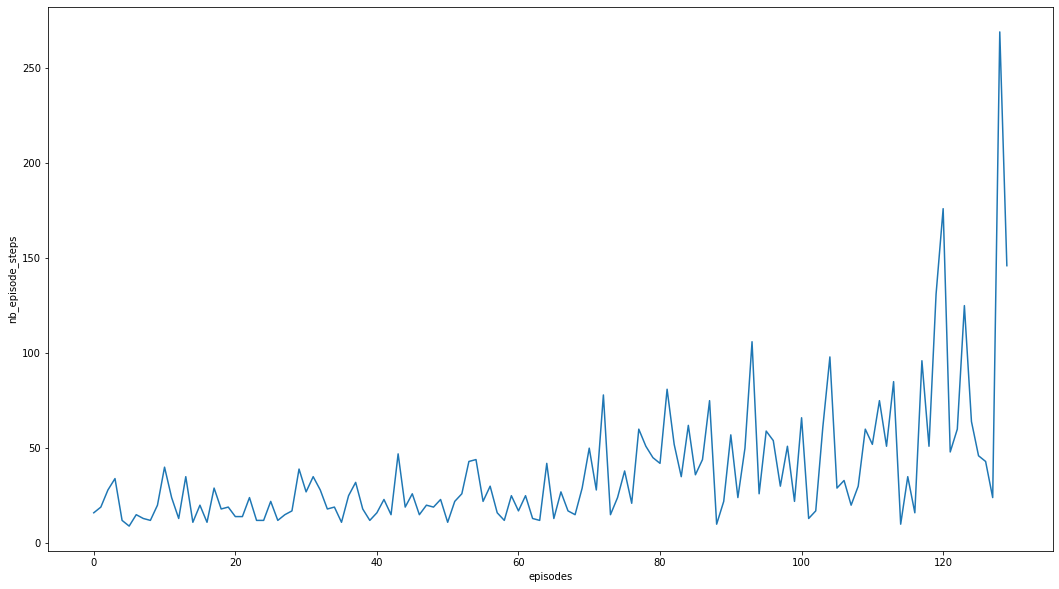

In [22]:
# Visualize the history for number of Training episode steps of the Cart Pole Game
plt.figure(figsize = (18,10))
plt.plot(history.history['nb_episode_steps'])
plt.ylabel('nb_episode_steps')
plt.xlabel('episodes')
plt.show()


In [23]:
# Finally, evaluate and test our algorithm for 100 episodes.
dqn.test(env, nb_episodes=100, visualize=False)

Testing for 100 episodes ...
Episode 1: reward: 223.000, steps: 223
Episode 2: reward: 350.000, steps: 350
Episode 3: reward: 217.000, steps: 217
Episode 4: reward: 264.000, steps: 264
Episode 5: reward: 209.000, steps: 209
Episode 6: reward: 222.000, steps: 222
Episode 7: reward: 186.000, steps: 186
Episode 8: reward: 498.000, steps: 498
Episode 9: reward: 223.000, steps: 223
Episode 10: reward: 243.000, steps: 243
Episode 11: reward: 500.000, steps: 500
Episode 12: reward: 250.000, steps: 250
Episode 13: reward: 365.000, steps: 365
Episode 14: reward: 415.000, steps: 415
Episode 15: reward: 211.000, steps: 211
Episode 16: reward: 223.000, steps: 223
Episode 17: reward: 500.000, steps: 500
Episode 18: reward: 182.000, steps: 182
Episode 19: reward: 193.000, steps: 193
Episode 20: reward: 416.000, steps: 416
Episode 21: reward: 337.000, steps: 337
Episode 22: reward: 327.000, steps: 327
Episode 23: reward: 319.000, steps: 319
Episode 24: reward: 202.000, steps: 202
Episode 25: reward: 

In [24]:
# After training is done, we save the final weights.
dqn.save_weights('dqn_weights.h5f', overwrite=False)

In [25]:
observation = env.reset()
dqn.load_weights('dqn_weights.h5f')
action = dqn.forward(observation)

print("Observation: ", observation)
print("Chosen action: ", action)

new_observation, reward, done, info = env.step(action)
print("Observations after action: ", new_observation)
print("Reward for this step: ", reward)
print("Episode Completion: ", done)

Observation:  [-0.03392113 -0.01289593  0.03837207  0.00320809]
Chosen action:  1
Observations after action:  [-0.03417905  0.1816553   0.03843623 -0.27712533]
Reward for this step:  1.0
Episode Completion:  False


## Task 2

Each Episode comprises of multiple steps. The environment is reset at the start of each episode as required. Next, the Agent makes the forward step based on the observation, before updating the new episode reward and observation for the next step. This continues until the termination criteria or truncation value of 500. Each cumulative reward is stored in a list and mapped out in the graph.

In [26]:
num_episodes = 100
episode_results = []
dqn.load_weights('dqn_weights.h5f')
for i in range(1,num_episodes+1):
    # Reset environment at the beginning of each episode
    observation = env.reset()
    cumulative_reward = 0
    done = False

    while not done:
        # Agent takes action based on observation
        action = dqn.forward(observation)
        
        # Environment processes action and returns new observation, reward, and done flag
        new_observation, reward, done, info = env.step(action)

        # Update episode reward and observation for next step
        observation = new_observation
        cumulative_reward += reward
        
    print("Episode:", i, " Cumulative reward: ", cumulative_reward)
    episode_results.append(cumulative_reward)

Episode: 1  Cumulative reward:  272.0
Episode: 2  Cumulative reward:  500.0
Episode: 3  Cumulative reward:  207.0
Episode: 4  Cumulative reward:  361.0
Episode: 5  Cumulative reward:  227.0
Episode: 6  Cumulative reward:  243.0
Episode: 7  Cumulative reward:  255.0
Episode: 8  Cumulative reward:  408.0
Episode: 9  Cumulative reward:  449.0
Episode: 10  Cumulative reward:  375.0
Episode: 11  Cumulative reward:  246.0
Episode: 12  Cumulative reward:  358.0
Episode: 13  Cumulative reward:  264.0
Episode: 14  Cumulative reward:  326.0
Episode: 15  Cumulative reward:  500.0
Episode: 16  Cumulative reward:  193.0
Episode: 17  Cumulative reward:  443.0
Episode: 18  Cumulative reward:  391.0
Episode: 19  Cumulative reward:  307.0
Episode: 20  Cumulative reward:  471.0
Episode: 21  Cumulative reward:  415.0
Episode: 22  Cumulative reward:  364.0
Episode: 23  Cumulative reward:  339.0
Episode: 24  Cumulative reward:  363.0
Episode: 25  Cumulative reward:  341.0
Episode: 26  Cumulative reward:  3

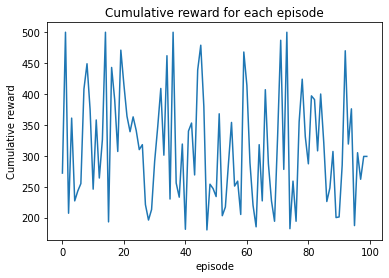

In [27]:
plt.plot(episode_results)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()

In [28]:
mean = sum(episode_results) / len(episode_results)
print("Average cumulative reward:", mean)
print("Is my agent good enough?", mean > 195)

Average cumulative reward: 313.91
Is my agent good enough? True


## Task 3

In [29]:
env = RecordVideo(gym.make("CartPole-v1"), "./video")
observation = env.reset()
while True:
    env.render()
    #your agent goes here
    action = dqn.forward(observation)
    observation, reward, done, info = env.step(action) 
    if done: 
      break;    
env.close()
show_video()